# Analysis on user timelines
To see how these user-timelines were downloaded, see:

`sm_w2v.__main__.run_user_timeline_download()`

Data were downloaded to:

`data/user_timeline_tweets.json`

In [1]:
# load and concatenate tweet timeline-documents
import json

train = True

user_timelines = dict()
with open('../data/user_timeline_tweets.json') as f_in:
    for l in f_in:
        try:
            twt = json.loads(l)
        except:
            continue
        user_id_str = twt['user']['id_str']
        if user_id_str in user_timelines:
            user_timelines[user_id_str] = user_timelines[user_id_str] + ' ' + twt['text']
        else:
            user_timelines[user_id_str] = twt['text']

# clean/preprocess text

In [2]:
from gensim.parsing.preprocessing import STOPWORDS
import re


STOPWORDS_ = ['rt', '', 'httpst', 'amp', 'https\'']

def clean_text(text):
    clean = re.sub(r'http.*$', '', text)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)

    clean = clean.lower()
    word_list = clean.split()
    word_list = [w for w in word_list if (w not in STOPWORDS_ and w not in STOPWORDS)]

    return word_list

user_clean_timelines = dict()
for user_id_str in user_timelines.keys():
    user_clean_timelines[user_id_str] = clean_text(user_timelines[user_id_str])

# LDA topic modeling on timeline documents

In [3]:
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim import corpora


user_timelines_keys = []
texts = []
for k, v in user_clean_timelines.items():
    user_timelines_keys.append(k)
    texts.append(v)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]

if train:
    print('number of user-timelines:', len(corpus))
    model = LdaModel(corpus, id2word=dictionary, num_topics=10, iterations=50, passes=5)
    model.save('../models/lda_user_timelines.model')

else:
    model = LdaModel.load('../models/lda_user_timelines.model')

number of user-timelines: 275


In [4]:
corpus

In [5]:
# idenitify topics of interest
model.print_topics(20)

[(0,
  '0.001*tw + 0.001*rihanna + 0.001*gta + 0.001*tnx + 0.001*globalgoals + 0.001*aidsfreegen + 0.001*asia + 0.001*thnx + 0.001*chevron + 0.001*partnerships'),
 (1,
  '0.001*photography + 0.001*adventure + 0.001*recipes + 0.001*disc + 0.001*hacking + 0.001*blogger + 0.001*px + 0.001*hospice + 0.001*dvd + 0.001*tested'),
 (2,
  '0.001*howto + 0.001*prolife + 0.001*pharmacy + 0.001*golf + 0.001*samuel + 0.001*monetary + 0.001*infinity + 0.001*responsibilities + 0.001*tampa + 0.001*lifestyle'),
 (3,
  '0.001*ini + 0.001*arsenal + 0.001*yang + 0.001*tim + 0.001*milan + 0.001*sos + 0.001*liz + 0.001*somalia + 0.001*pittsburgh + 0.001*closed'),
 (4,
  '0.001*remedies + 0.001*indonesia + 0.001*missions + 0.001*rid + 0.001*bitcoin + 0.001*ootd + 0.001*courage + 0.001*rs + 0.001*alzheimers + 0.001*ultrasound'),
 (5,
  '0.001*clinicians + 0.001*cbd + 0.001*publichealth + 0.001*std + 0.001*hiking + 0.001*taylorswift + 0.001*tunein + 0.001*ngo + 0.001*contracted + 0.001*hahahaha'),
 (6,
  '0.00

In [6]:
# show users vs. features (topics)
features = dict()

for i, doc in enumerate(corpus):
    features[user_timelines_keys[i]] = model.get_document_topics(doc, minimum_probability=None)


In [7]:
# do time-plot of features for a specific user (topics) vs. time
import pandas as pd
import numpy as np

columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5',
           'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
index = user_timelines_keys
df = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns=columns, index=index)

for doc_ind, user_doc in enumerate(features.values()):
    for topic in user_doc:
        df.iloc[doc_ind, topic[0]] = topic[1]

In [8]:
df.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
3019793950,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.918076,0.000000
768904033,0.01,0.01,0.010002,0.010006,0.010000,0.01,0.010022,0.010002,0.909965,0.010003
125209174,0.00,0.00,0.000000,0.521646,0.000000,0.00,0.000000,0.000000,0.403609,0.000000
2902235927,0.00,0.00,0.000000,0.000000,0.538709,0.00,0.000000,0.000000,0.388004,0.000000
251643565,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.136489,0.000000,0.829220,0.000000


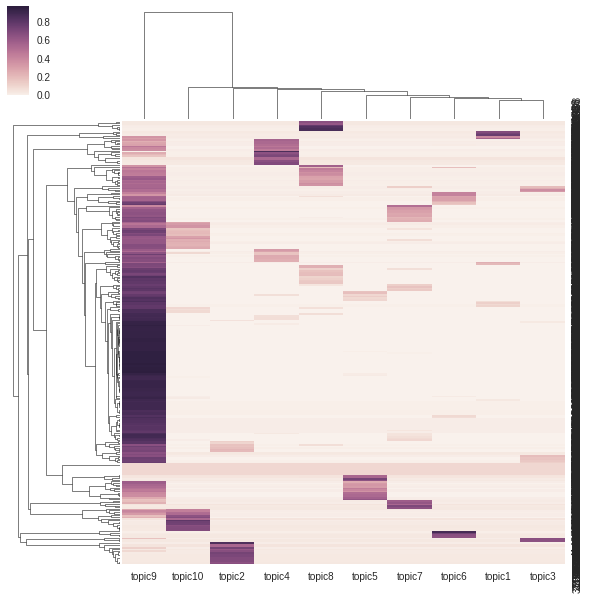

In [9]:
import seaborn as sns
%matplotlib inline

sns.clustermap(df)

In [10]:
# do Doc2Vec to cluster user-timelines (documents)